# TP1 - Compressão e Descompressão de Imagem

### Alunos:

Vinicius Silva Gomes - 2021421869

João Antonio Oliveira Pedrosa - 2019006752

# Compressão de Imagem

Fizemos dois métodos de compressão para o trabalho. O primeiro deles é inspirado na compressão realizada pelo JPEG, se diferenciando na forma de codificar os bits da imagem para salvar em disco e, consequentemente, na sua decodificação. O segundo deles é um método mais matemático, que é a compressão através da Decomposição em Valores Singulares.

Ambos os métodos serão melhor detalhados ao longo do código e previamente antes dele ser apresentado.

In [152]:
# Library import

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
from queue import Queue

In [153]:
# Variables and auxiliar functions

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def pad_img(img):
    # Padding image
    img_shape = img.shape

    lin    = img_shape[0]
    col    = img_shape[1]
    xpad   = (SQ - lin % SQ) % SQ
    ypad   = (SQ - col % SQ) % SQ

    padded_img = img.copy()
    padded_img = np.append(padded_img, np.full((xpad, col)       , 255), axis = 0)
    padded_img = np.append(padded_img, np.full((lin + xpad, ypad), 255), axis = 1)
    
    return padded_img

def unpad_img(img, shape):
    # Unpadding image
    img_shape = shape

    lin    = img_shape[0]
    col    = img_shape[1]

    return img[:lin, :col] 

SQ = 8

# Default quantization matrix implemented by JPEG compression method
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]])

## Primeiro método de Compressão
Transformada Discreta do Cosseno + Quantização através da tabela padrão utilizada pelo JPEG + Codificação através de array que minimiza a incidência de zeros.

Para este método de compressão, é realizada a transformação da imagem do domínio espacial para o domínio de frequência. Essa transformação é feita através da Transformada Discreta do Cosseno em blocos de tamanho 8x8. Para que não haja problemas com as dimensões da imagem, antes de sofrer a transformada, a imagem passar por um processo de padding para que ela seja múltipla de 8.

Após a transformada, a imagem é quantizada por meio de uma tabela de quantização. Essa tabela tem como função minimizar os coeficientes de alta frequência e manter somente os de baixa e média frequência (faixa de frequência visível a olho nu). A tabela de quantização utilizada é mesma utilizada pelo JPEG, que possui uma taxa de compressão satisfatória e não prejudica a visualização do conteúdo da imagem.

Por fim, a imagem será codificada e salva em disco. A codificação acontece bloco a bloco e é feita de forma que cada fim de linha é representado por um caractere (126) e cada fim de bloco é representado por outro caractere (127). Os 0s a direita são omitidos e apenas os caracteres delimitadores e os coeficientes diferentes de 0 são salvos. Dessa forma, graças a grande quantidade de coeficientes 0 obtidos através da DCT + Quantização, um bloco 8x8 pode ser reduzido para um array unidimensional muito menor.

Com isso, serão salvos as dimensões originais da imagem, sem padding, e os blocos codificados pelo algoritmo. Salvando dessa forma, é possível recriar a imagem original (com algumas perdas graças a DCT + Quantização) usando muito menos espaço de armazenamento em disco.

### Breve descrição de cada função utilizada no método de compressão:

* num_to_array & array_to_num:
    > Transformam números menores que $2^{32}$ em um array de 4 números menores que $2^8$. Isso é utilizado para que números maiores possam ser salvos em um array com tipo np.int8.

* apply_dct & apply_idct:
    > Aplica e retorna a DCT e a IDCT num bloco 8x8 da imagem.
    
* simplify_block & desimplify_block:
    > Simplifica o bloco 8x8 e o transforma num vetor unidimensional que é limitado pelos caracteres 126 e 127 (caracterizam o fim da linha do bloco e o fim do bloco, respectivamente). A função que dessimplifica aplica o processo inverso e retorna o bloco 8x8 que originou aquela codificação.
   
* encode_block & decode_block:
    > Recebe um bloco da imagem original e aplica as funções anteriores na seguinte ordem:
        padding -> DCT -> simplify_block.
    > O decode_block aplica o processo inverso:
        desimplify_block -> IDCT -> unpad
    
* encode_img & decode_img:
    > Aplica o encode_block em todos os blocos 8x8 da imagem recebida.
    > Decode faz o inverso desse processo, obtendo a imagem original.
    
* svd_compression & svd_decompression
    > Calcula as matrizes U, Σ e V; salva elas no arquivo de acordo com a quantidade de valores singulares que serão salvos. A função de descompressão recupera as matrizes e U, Σ e V e calcula o produto interno entre elas para recuperar a imagem original.

In [154]:
# Function to transform any number smaller than 2^32 into a 8bit array
def num_to_array(num):
    bits     = [1 if (num & (1 << i)) else 0 for i in range(32)]
    
    response = []
    for i in range(4):
        cur_num = 0
        for j in range(8):
            if(bits[i*8 + j]):
                cur_num += (1 << j)
        response.append(cur_num)
    
    response = [x - 128 for x in response]
    return response

# Function to reverse a 8bit array into the original number
def array_to_num(arr):
    arr  = [x + 128 for x in arr]
    bits = []
    for i in range(4):
        for j in range(8):
            if(arr[i] & (1 << j)):
                bits.append(1)
            else:
                bits.append(0)
    
    num = 0
    for i in range(32):
        if(bits[i]):
            num += (1 << i)
    
    return num
    
# Apply DCT to a SQxSQ image block
def apply_dct(block):
    image = block.copy()
    
    image -= 128
    image =  image.astype(float)
    return cv2.dct(image)

# Apply IDCT to a SQxSQ image block
def apply_idct(block):
    image = block.copy()
    image =  image.astype(float)
    image = cv2.idct(image)
    image += 128
    return image

# Used to guarantee consistent numbers in simple array
def f(num):
    if num == 127:
        return 125
    if num == 126:
        return 125
    
    return num

def desimplify_block(block):
    desimple = []
    line     = []
    for num in block:
        if num == 127:
            break
        elif num == 126:
            line += [0 for i in range(SQ - len(line))]
            desimple.append(line)
            line = []
        else:
            line.append(num)
            
    # Padding
    for i in range(SQ - len(desimple)):
        desimple.append([0] * 8)
    
    return np.array(desimple)

# Simplify the block writing an unidimensional array divided by arbitrary codes:
# 126  is used to store line ending
# 127 is used to store block ending
# That way we can simplify a SQxSQ block into a smaller array and then convert it back to a SQxSQ block
def simplify_block(block):
    simple = []
    for i in range(SQ):
        # Transform line
        line = []
        for j in reversed(range(SQ)):
            if line:
                line.append(f(block[i][j]))
            elif(block[i][j] != 0):
                line.append(126)
                line.append(f(block[i][j]))
        
        line.reverse()
        simple += line
    
    simple.append(127)
    
    return simple

# Encode a SQxSQ block, returning the simplified version of the block
def encode_block(block):
    local_dct        = apply_dct(block)
    local_quant      = local_dct / quant_matrix
    local_quant      = local_quant.round()
    
    return simplify_block(local_quant)

# Decode a SQxSQ block, returning the original block from the image
def decode_block(block):
    local_block = desimplify_block(block)
    
    return apply_idct(local_block * quant_matrix)

def encode_img(img):
    # Adding dimensions to start of array
    xshape, yshape = img.shape
    encoded = num_to_array(xshape) + num_to_array(yshape)
    
    padded_img = pad_img(img)
    
    lin = padded_img.shape[0]
    col = padded_img.shape[1]
    for l in tqdm(range(0, lin, SQ)):
        for c in range(0, col, SQ):
            encoded += encode_block(padded_img[l:l+SQ, c:c+SQ])
    
    return np.array(encoded, dtype=np.int8)
    
def decode_img(img):
    # enc = np.load('results/compressed_dct.npy')
    enc     = img.copy()
    x_orig  = array_to_num(np.array(enc[0:4]))
    y_orig  = array_to_num(np.array(enc[4:8]))
    x_shape = x_orig + x_orig % SQ
    y_shape = y_orig + y_orig % SQ
    
    # Remove dimensions from array
    enc     = enc[8:]
    
    blocks    = Queue()
    cur_block = []
    for x in enc:
        cur_block.append(x)
        if x == 127:
            blocks.put(cur_block)
            cur_block = []
    
    dec     = np.zeros((x_shape, y_shape))
    for l in tqdm(range(0, x_shape, SQ)):
        for c in range(0, y_shape, SQ):
            if not blocks.empty():
                cur_block = blocks.get()
                dec[l:l+SQ, c:c+SQ] = decode_block(cur_block)
    
    return unpad_img(dec, (x_orig, y_orig))

def save_img(img, path):
    coded    = encode_img(img)
    np.save(path, coded)
    
def load_img(path):
    try:
        coded = np.load(path)
    except:
        raise Exception("Error while loading file. Probably due to bad path.")
        
    return decode_img(coded)

## Exemplos de Uso
Segue um exemplo de uso do compressor de imagens.

Insira o caminho para uma imagem que vocês deseja comprimir: Adventure_Time_3.png


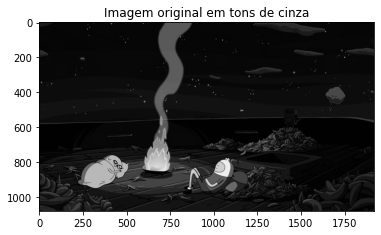

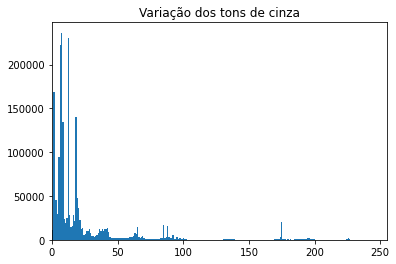

Dimensões da imagem: 1920x1080
Tamanho da imagem (em disco): 1.1452 MB / 1172.7344 kB


In [155]:
path = input("Insira o caminho para uma imagem que vocês deseja comprimir:")

# Importing the image and information about it's dimensions and size
src_img = cv2.imread(path, 0)
src_img_size = os.stat(path).st_size

# Carregando imagem
plt.title("Imagem original em tons de cinza")
plt.imshow(src_img, cmap="gray")
plt.figure()

# Histogram with image gray levels
src_img = pad_img(src_img)
flattered_img = src_img.ravel()

plt.hist(flattered_img, 256, [0,255]);
plt.xlim([0, 255])
plt.title("Variação dos tons de cinza")
plt.show()

print("Dimensões da imagem: {}x{}".format(src_img.shape[1], src_img.shape[0]))
print("Tamanho da imagem (em disco): {:.4f} MB / {:.4f} kB".format(src_img_size/2 ** 20, src_img_size/2 ** 10))

Salvando imagem em disco com o compressor:

In [156]:
path_result = input("Digite um nome para o arquivo comprimido (Sem extensão):")
save_img(src_img, path_result)
path_result += ".npy"

size = os.path.getsize(path_result)
print("Imagem salva. Tamanho do arquivo (em disco): {:.4f} MB / {:.4f} kB".format(size/2 ** 20, size/2 ** 10))

Digite um nome para o arquivo comprimido (Sem extensão): Adventure_Compressed


100%|████████████████████████████████████████| 135/135 [00:01<00:00, 114.92it/s]

Imagem salva. Tamanho do arquivo (em disco): 0.1968 MB / 201.5098 kB


Descomprimindo o arquivo em disco e carregando a imagem novamente:

100%|████████████████████████████████████████| 135/135 [00:01<00:00, 115.93it/s]


RMSE: 2.206562380794809
PSNR: 41.25647941441972
Taxa de compressão: 5.8197


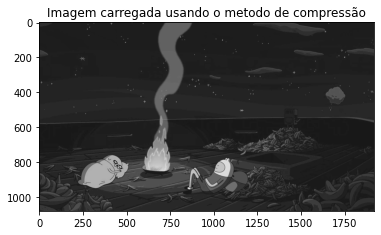

In [157]:
decompressed = load_img(path_result)
plt.title("Imagem carregada usando o metodo de compressão")
plt.imshow(decompressed, cmap="gray")

print("RMSE:", rmse(decompressed, src_img))
print("PSNR:", psnr(decompressed, src_img))
print("Taxa de compressão: {:.4f}".format(src_img_size / size))

## Segundo método de compressão
Compressão baseado na Decomposição em Valores Singulares.

A compressão por Decomposição em Valores Singulares se baseia na propriedade de que qualquer matriz pode ser decomposta em 3 matrizes U, Σ e V; de modo que a multiplicação IMG = UΣV resulta na matriz que originou a decomposição.

A compressão desse método se baseia no fato que essas matrizes possuem tamanho inferior ao tamanho original da imagem e elas são dependentes do número de valores singulares que serão usados para recompor a imagem. Quanto mais valores singulares usados, maior será a fidelidade da imagem reconstruída e, consequentemente, menor será a compressão.

No exemplo que foi codificado, são usados aproximadamente 20% dos valores singulares da matriz. Com essa quantidade de valores, é possível reconstruir a imagem de modo que é possível identificar claramente o conteúdo presente nela, mas os ruídos e as perdas de cores são bem notáveis. Além disso, é possível obter uma taxa de compressão relativamente boa, como pode ser observado nos prints na próxima célula.

In [7]:
# Compress the image, saving the U, Σ and V matrices in the disk
def svd_compression(img, path):
    U, sigma, V = np.linalg.svd(img, full_matrices=False) # Calculates U, V and the singular values of the original matrix
    
    rank = len(sigma)
    
    k = round(0.2 * rank) # Estimate the number of singular values
        
    U_new = U[:,:k]
    V_new = V[:k,:]
    S_new = np.zeros((k, k), int)
    
    for i in range(k):
        S_new[i][i] = sigma[i]
        
    file = open(path + ".bin" ,"wb")
    
    np.save(file, U_new)
    np.save(file, S_new)
    np.save(file, V_new)
    
    file.close()
    
    return k

# Load matrices from disk into memory and perform multiplication to get the original matrix
def svd_decompression(path):
    file = open(path ,"rb")
    
    U = np.load(file)
    sigma = np.load(file)
    V = np.load(file)
    
    file.close()
        
    uncompressed_img = np.dot(np.dot(U, sigma), V)
    
    return uncompressed_img

# Calculate the compression rate for SVD compression
# Compressão 'virtual', não leva em conta a quantidade de bits salvas, só a quantidade de informações que serão salvas em disco
def compression_rate(img, singular_values):
    original_size = img.shape[0] * img.shape[1]
    compressed_size = singular_values * (1 + img.shape[0] + img.shape[1])
    
    return original_size / compressed_size

## Exemplos de Uso
Segue um exemplo de uso do compressor de imagens.

Insira o caminho para uma imagem que vocês deseja comprimir:apples.jpg


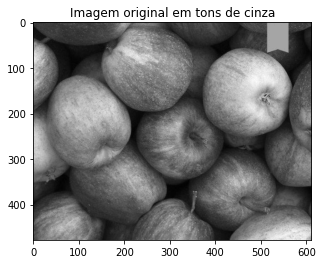

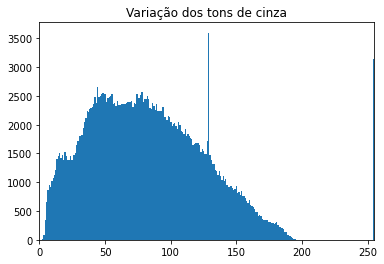

Dimensões da imagem: 616x480
Tamanho da imagem (em disco): 0.0566 MB / 57.9668 kB


In [9]:
path_svd = input("Insira o caminho para uma imagem que vocês deseja comprimir:")

# Importing the image and information about it's dimensions and size
svd_img = cv2.imread(path_svd, 0)
svd_img_size = os.stat(path_svd).st_size

# Carregando imagem
plt.title("Imagem original em tons de cinza")
plt.imshow(svd_img, cmap="gray")
plt.figure()

# Histogram with image gray levels
svd_img = pad_img(svd_img)
flattered_img = svd_img.ravel()

plt.hist(flattered_img, 256, [0,255]);
plt.xlim([0, 255])
plt.title("Variação dos tons de cinza")
plt.show()

print("Dimensões da imagem: {}x{}".format(svd_img.shape[1], svd_img.shape[0]))
print("Tamanho da imagem (em disco): {:.4f} MB / {:.4f} kB".format(svd_img_size/2 ** 20, svd_img_size/2 ** 10))

Salvando imagem em disco com o compressor:

In [10]:
path_result_svd = input("Digite um nome para o arquivo comprimido (Sem extensão):")
singular_values = svd_compression(svd_img, path_result_svd)
path_result_svd += ".bin"

size_svd = os.path.getsize(path_result_svd)
print("Imagem salva. Tamanho do arquivo (em disco): {:.4f} MB / {:.4f} kB".format(size_svd/2 ** 20, size_svd/2 ** 10))

Digite um nome para o arquivo comprimido (Sem extensão):apples_svd
Imagem salva. Tamanho do arquivo (em disco): 0.8734 MB / 894.3750 kB


Descomprimindo o arquivo em disco e carregando a imagem novamente:

RMSE: 3.510043340708453
PSNR: 37.224554028568804
Compression Rate: 2.807657247037375


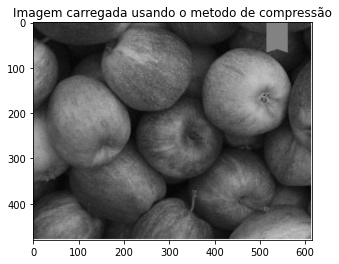

In [12]:
uncompressed_img = svd_decompression(path_result_svd)

plt.title("Imagem carregada usando o metodo de compressão")
plt.imshow(uncompressed_img, cmap="gray")

print("RMSE:", rmse(svd_img, uncompressed_img))
print("PSNR:", psnr(svd_img, uncompressed_img))
print("Compression Rate:", compression_rate(svd_img, singular_values))